# Text Representation

In [195]:
import os
import re
import time
import pickle
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IndexerCACM import *
from RelevantParser import *
from Query import *
from copy import *
from ggplot import *

### Get Indexers

In [3]:
# Processed collections 
collectionPath = 'data/cacm/cacm.txt'
collectionPath2 = 'data/cisi/cisi.txt'
queriesPath = 'data/cacm/cacm.qry'
relevantPath = 'data/cacm/cacm.rel'

In [4]:
indexer = IndexerCACM(collectionPath, ParserCACM())

# If Index and Inv Index aren't already builded
#indexer.createRepIndex()
#indexer.createRepInvIndex()
#indexer.createRepInvFromAll()

queriesIndexer = IndexerCACM(queriesPath, ParserCACM())

# If Index isn't already builded
#queriesIndexer.createRepIndex()

relevantIndexer = Indexer(relevantPath, RelevantParser())

# If Index and Inv Index aren't already builded
#relevantIndexer.createIndex()

In [171]:
q = query(1, queriesIndexer, relevantIndexer)
q2 = query(2, queriesIndexer, relevantIndexer)
q3 = query(3, queriesIndexer, relevantIndexer)
q4 = query(4, queriesIndexer, relevantIndexer)
q7 = query(7, queriesIndexer, relevantIndexer)
print(q, q2, q3, q4, q7)

(<Query.Query object at 0x7f22cd625d10>, <Query.Query object at 0x7f22cd625dd0>, <Query.Query object at 0x7f22e051f910>, <Query.Query object at 0x7f22cd625650>, <Query.Query object at 0x7f22e051f0d0>)


# Weighter

In [146]:
class Weighter(object):
    
    def __init__(self, indexer):
        
        # Indexer is an Indexer object
        self.indexer = indexer
        
        self.nDoc = len(indexer.indexFromCol)
        self.loadIndex = {}
        
        
    def idf(self, elements):
        
        result = {}
        
        for element in elements:
            if element in self.indexer.invIndex:
                result[element] = \
                self.nDoc / float(len(self.indexer.getDfFromEl(element))-1)
            else:
                result[element] = 0
        
        return result
        
    def loadWeightsFromDoc(self, name):
        
        end = re.search(r'\..*?$', self.indexer.collectionPath).group(0)
        self.path = re.sub(r'\..*?$', name, self.indexer.collectionPath)+end
        self.indexPath = re.sub(r'\..*?$', 'Index', self.path)+end
        
        if os.path.isfile(self.indexPath):
            indexFile = open(self.indexPath)
            self.loadIndex = pickle.load(indexFile)
            indexFile.close()
        else:
            weightsFile = open(self.path, "w")
            pos = 0
            for id in self.indexer.index:
                toWrite = ''
                elements = self.computeWeightsFromDoc(id)
                elements.pop(-1)
                for element in elements:
                    toWrite += ':'+element+':'+str(elements[element])
                toWrite = toWrite[1:]
                # Get pos in index and size of current rep
                self.loadIndex[id] = [pos, len(toWrite)]
                
                weightsFile.write(toWrite)
                pos += len(toWrite)

            weightsFile.close()
            
            # Indexes'hashtable of doc in col
            indexFile = open(self.indexPath, "w")
            pickle.dump(self.loadIndex, indexFile)
        
            indexFile.close()
            
    def getWeightsFromDoc(self, id):
        
        data = self.indexer.getData(self.path, self.loadIndex, id)
        return self.indexer.freqFromData(data)
        
    def computeWeightsFromDoc(self, id):
        
        raise ValueError('Abstract method')
    
    def getWeightsFromQuery(self, query):
        
        raise ValueError('Abstract method')
        
            
class Weighter1(Weighter):
    
    def __init__(self, indexer):
        
        Weighter.__init__(self, indexer)
        name = 'Weighter1'
        self.loadWeightsFromDoc(name)
        
    def computeWeightsFromDoc(self, id):
        
        return self.indexer.getEfFromDoc(id)
    
    def getWeightsFromQuery(self, query):
        
        weights = copy(query)
        
        for element in weights:
            weights[element] = 1
        
        return weights
        
class Weighter2(Weighter):
    
    def __init__(self, indexer):
        
        Weighter.__init__(self, indexer)
        name = 'Weighter2'
        self.loadWeightsFromDoc(name)
        
    def computeWeightsFromDoc(self, id):
        
        return self.indexer.getEfFromDoc(id)
    
    def getWeightsFromQuery(self, query):
        
        weights = copy(query)
        
        return weights
        
class Weighter3(Weighter):
    
    def __init__(self, indexer):
        
        Weighter.__init__(self, indexer)
        name = 'Weighter3'
        self.loadWeightsFromDoc(name)
        
    def computeWeightsFromDoc(self, id):
        
        return self.indexer.getEfFromDoc(id)
    
    def getWeightsFromQuery(self, query):
        
        return self.idf(query)

class Weighter4(Weighter):
    
    def __init__(self, indexer):
        
        Weighter.__init__(self, indexer)
        name = 'Weighter4'
        self.loadWeightsFromDoc(name)
        
    def computeWeightsFromDoc(self, id):
        
        weights = self.indexer.getEfFromDoc(id)
        
        for element in weights:
            weights[element] = 1 + np.log(weights[element])
            
        return weights
    
    def getWeightsFromQuery(self, query):
        
        return self.idf(query)
                       
class Weighter5(Weighter):
    
    def __init__(self, indexer):
        
        Weighter.__init__(self, indexer)
        name = 'Weighter5'
        self.loadWeightsFromDoc(name)
        
    def computeWeightsFromDoc(self, id):
        
        weights = self.indexer.getEfFromDoc(id)
        
        idf = self.idf(weights)
        
        for element in weights:
            weights[element] = \
            (1 + np.log(weights[element])) * idf[element]
            
        return weights
    
    def getWeightsFromQuery(self, query):
        
        weights = copy(query)
        
        idf = self.idf(weights)
        
        for element in weights:
            weights[element] = \
            (1 + np.log(weights[element])) * idf[element]
            
        return weights


In [172]:
w = Weighter1(indexer)
print(w.getWeightsFromDoc(20))
print('\n')
print(w.getWeightsFromQuery(q7.el))

{'acceler': 1.0, 'techniqu': 1.0, 'process': 1.0, 'appli': 1.0, 'induc': 1.0, 'solut': 1.0, 'wegstein': 1.0, 'procedur': 1.0, 'converg': 4.0, 'rate': 1.0, 'exampl': 1.0, 'diverg': 1.0, 'iter': 4.0, 'illustr': 1.0, 'accelerat': 1.0, 'discuss': 1.0, -1: 23.0, 'equat': 1.0}


{'distribut': 1, 'process': 1, 'concurr': 1, 'understand': 1, 'pass': 1, 'toler': 1, 'techniqu': 1, 'algorithm': 1, 'commun': 1, 'fault': 1, 'area': 1, 'messag': 1, 'synchronize': 1, 'program': 1, 'includ': 1, 'interest': 1, 'correct': 1, -1: 1}


In [173]:
w = Weighter2(indexer)
print(w.getWeightsFromDoc(111))
print('\n')
print(w.getWeightsFromQuery(q7.el))

{'comput': 1.0, 'bairstow': 1.0, 'illustr': 1.0, 'appli': 2.0, 'newton': 1.0, 'raphson': 1.0, 'high': 1.0, 'rule': 1.0, 'polynomial': 2.0, 'pitfal': 1.0, 'ellenberg': 1.0, 'shown': 1.0, 'rapid': 1.0, 'techniqu': 2.0, 'solut': 1.0, 'invers': 1.0, 'accuraci': 1.0, 'circumv': 1.0, 'exampl': 1.0, 'basic': 1.0, 'applic': 1.0, 'numer': 3.0, 'recommend': 2.0, 'scale': 1.0, 'procedur': 1.0, 'present': 1.0, 'great': 1.0, 'reliabl': 1.0, 'iter': 1.0, 'converg': 1.0, 'degre': 1.0, 'realiz': 1.0, 'equat': 2.0, 'programm': 1.0, 'root': 1.0, -1: 42.0}


{'distribut': 1.0, 'process': 1.0, 'concurr': 1.0, 'understand': 1.0, 'pass': 1.0, 'toler': 1.0, 'techniqu': 1.0, 'algorithm': 2.0, 'commun': 1.0, 'fault': 1.0, 'area': 1.0, 'messag': 1.0, 'synchronize': 1.0, 'program': 1.0, 'includ': 1.0, 'interest': 1.0, 'correct': 1.0, -1: 18.0}


In [174]:
w = Weighter3(indexer)
print(w.getWeightsFromDoc(400))
print('\n')
print(w.getWeightsFromQuery(q7.el))

{'comment': 1.0, 'feurzeig': 1.0, 'procedur': 1.0, -1: 8.0, 'iron': 1.0, 'implement': 1.0, 'recurs': 1.0, 'algol': 1.0, 'block': 1.0}


{'concurr': 14.299319727891156, 'distribut': 11.301075268817204, 'algorithm': 2.5823095823095823, 'commun': 8.308300395256918, 'process': 5.871508379888268, 'fault': 15.984790874524714, 'area': 11.943181818181818, 'messag': 13.828947368421053, 'synchronize': 2102.0, 'program': 5.120584652862363, 'understand': 14.80281690140845, 'includ': 9.731481481481481, 'interest': 161.69230769230768, 'pass': 13.561290322580644, 'toler': 15.864150943396226, 'correct': 11.710306406685238, -1: 0, 'techniqu': 7.006666666666667}


In [175]:
w = Weighter4(indexer)
print(w.getWeightsFromDoc(400))
print('\n')
print(w.getWeightsFromQuery(q7.el))

{'comment': 1.0, 'feurzeig': 1.0, 'procedur': 1.0, -1: 8.0, 'iron': 1.0, 'implement': 1.0, 'recurs': 1.0, 'algol': 1.0, 'block': 1.0}


{'concurr': 14.299319727891156, 'distribut': 11.301075268817204, 'algorithm': 2.5823095823095823, 'commun': 8.308300395256918, 'process': 5.871508379888268, 'fault': 15.984790874524714, 'area': 11.943181818181818, 'messag': 13.828947368421053, 'synchronize': 2102.0, 'program': 5.120584652862363, 'understand': 14.80281690140845, 'includ': 9.731481481481481, 'interest': 161.69230769230768, 'pass': 13.561290322580644, 'toler': 15.864150943396226, 'correct': 11.710306406685238, -1: 0, 'techniqu': 7.006666666666667}


In [176]:
w = Weighter5(indexer)
print(w.getWeightsFromDoc(111))
print('\n')
print(w.getWeightsFromQuery(q7.el))

{'comput': 2.83862255233, 'bairstow': 14.8551236749, 'illustr': 13.1786833856, 'appli': 18.0659663631, 'newton': 13.4743589744, 'raphson': 15.9242424242, 'high': 12.8562691131, 'rule': 11.1808510638, 'polynomial': 57.4031511861, 'pitfal': 16.2945736434, 'ellenberg': 15.3430656934, 'shown': 8.72199170124, 'rapid': 14.5467128028, 'techniqu': 11.8633179118, 'solut': 9.02145922747, 'invers': 55.3157894737, 'accuraci': 15.231884058, 'circumv': 16.421875, 'exampl': 9.32150776053, 'basic': 11.3010752688, 'applic': 7.78518518519, 'numer': 21.2080914941, 'recommend': 25.5125116383, 'scale': 6.04892086331, 'procedur': 7.91713747646, 'present': 5.39666238768, 'great': 14.750877193, 'reliabl': 13.6493506494, 'iter': 12.7009063444, 'converg': 15.4558823529, 'degre': 85.7959183673, 'realiz': 14.0133333333, 'equat': 16.7877140261, 'programm': 5.74316939891, 'root': 12.3284457478, -1: 608.25462773682}


{'distribut': 11.301075268817204, 'process': 5.8715083798882679, 'concurr': 14.299319727891156, 'un

# Similarity measure

In [13]:
class IRmodel(object):
    
    def __init__(self, indexer):
        
        # indexer is an indexer object
        self.indexer = indexer
        self.nDoc = len(indexer.indexFromCol)
        
    def getScores(self, query):
        
        raise ValueError('Abstract method')
    
    def getRanking(self, query):
        
        start = time.time()
        
        scores = self.getScores(query)
        sorted_scores = (np.sort(scores, order='score'))[::-1]
        
        end = time.time()
        
        return sorted_scores

class Vector(IRmodel):
    
    def __init__(self, indexer, weighter=Weighter1, normalized=False):
    
        IRmodel.__init__(self, indexer)
        
        # weighter is a Weighter object
        self.weighter = weighter(indexer)
        
        # normalized is a boolean
        self.normalized = normalized
    
    def dotProduct(self, vector1, vector2):
        
        result = 0
        
        if len(vector1)>len(vector2):
            tmp = vector1
            vector1 = vector2
            vector2 = tmp
        
        for element in vector1:
            if element in vector2:
                result += vector1[element]*vector2[element]
        
        return result
                
    def norm2(self, vector):
        
        result = 0
        
        for element in vector:
            result += float(np.power(vector[element], 2))
        
        return float(np.sqrt(result))
    
    def getScores(self, query):
        
        vecQuery = self.weighter.getWeightsFromQuery(query)
        vecQuery.pop(-1)
        norm2VecQuery = self.norm2(vecQuery)
        
        doc = {}
        
        for id in query:
            
            if id in self.indexer.invIndex:
                for element in self.indexer.getDfFromEl(id):
                    doc[element] = id
        doc.pop(-1)
        
        scores = np.zeros(self.nDoc, [('id', 'a25'), ('score', 'float64')])
        
        i = 0 
        for id in self.indexer.index:
            
            scores[i]['id'] = str(id)
            
            if id in doc:
                vecDoc = self.weighter.getWeightsFromDoc(id)
                vecDoc.pop(-1)
                dotProduct = self.dotProduct(vecDoc, vecQuery)

                if self.normalized: 
                    scores[i]['score'] = dotProduct/(self.norm2(vecDoc)*norm2VecQuery)
                else:
                    scores[i]['score'] = dotProduct

            else:
                scores[i]['score'] = 0
                
            i += 1
        
        return np.array(scores)
        

In [177]:
vector1 = Vector(indexer, Weighter1)
scores1 = vector1.getRanking(q7.el)
scores1[:10]

array([('3043', 19.0), ('3014', 19.0), ('3715', 17.0), ('3568', 17.0),
       ('3206', 17.0), ('3104', 17.0), ('3077', 17.0), ('1922', 17.0),
       ('4003', 16.0), ('3372', 16.0)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [178]:
vectorNorm1 = Vector(indexer, Weighter1, normalized=True)
scoresNorm1 = vectorNorm1.getRanking(q7.el)
scoresNorm1[:10]

array([('3043', 0.3325665199566524), ('3104', 0.3322493196224943),
       ('2376', 0.31526414437773154), ('3141', 0.30678599553894814),
       ('2657', 0.280056016805602), ('3170', 0.27500954910846337),
       ('1941', 0.26906911759852503), ('1778', 0.26906911759852503),
       ('2080', 0.2655273953168418), ('2896', 0.2556549962824568)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [179]:
vector2 = Vector(indexer, Weighter2)
scores2 = vector2.getRanking(q7.el)
scores2[:10]

array([('2657', 23.0), ('2902', 22.0), ('2263', 22.0), ('2767', 21.0),
       ('3568', 20.0), ('2903', 20.0), ('2862', 20.0), ('2146', 20.0),
       ('1946', 20.0), ('3206', 19.0)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [180]:
vectorNorm2 = Vector(indexer, Weighter2, normalized=True)
scoresNorm2 = vectorNorm2.getRanking(q7.el)
scoresNorm2[:10]

array([('371', 0.40451991747794525), ('3141', 0.37712361663282534),
       ('2657', 0.3711609040115441), ('199', 0.3651483716701107),
       ('2042', 0.3464101615137754), ('711', 0.33541019662496846),
       ('2903', 0.31862649393858306), ('740', 0.31622776601683794),
       ('445', 0.31622776601683794), ('356', 0.31622776601683794)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [181]:
vector3 = Vector(indexer, Weighter3)
scores3 = vector3.getRanking(q7.el)
scores3[:10]

array([('3043', 2263.4224095700433), ('2740', 2153.3090176118512),
       ('2850', 242.60228648961902), ('3080', 220.95701307571468),
       ('3715', 208.92688965456418), ('1145', 204.5017626096979),
       ('3840', 203.62036697019047), ('1604', 195.2865512626927),
       ('2866', 194.70860049355073), ('3372', 192.58488951384837)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [182]:
vectorNorm3 = Vector(indexer, Weighter3, normalized=True)
scoresNorm3 = vectorNorm3.getRanking(q7.el)
scoresNorm3[:10]

array([('3043', 0.07746469184750462), ('2740', 0.06261153358410143),
       ('1364', 0.012779883932154418), ('1604', 0.01076577444387861),
       ('1383', 0.010339435187225647), ('1014', 0.01021275204809648),
       ('435', 0.009963427254114064), ('2804', 0.009899255527139564),
       ('2866', 0.009843115919132893), ('971', 0.009540470859395965)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [183]:
vector4 = Vector(indexer, Weighter4)
scores4 = vector4.getRanking(q7.el)
scores4[:10]

array([('3043', 2200.856043977451), ('2740', 2137.701546444129),
       ('1145', 200.60283464744234), ('3080', 196.6043622662686),
       ('2850', 196.01389763292258), ('2866', 194.70860049355073),
       ('1604', 191.8187844537525), ('1743', 187.4697894884677),
       ('616', 186.43645245275837), ('1623', 185.76274083001852)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [184]:
vectorNorm4 = Vector(indexer, Weighter4, normalized=True)
scoresNorm4 = vectorNorm4.getRanking(q7.el)
scoresNorm4[:10]

array([('3043', 0.10630703036744663), ('2740', 0.09361773775100722),
       ('1364', 0.013429744400820145), ('1604', 0.012578620063956913),
       ('2804', 0.012403670643438086), ('1383', 0.012274088373624228),
       ('971', 0.012076251644817867), ('1743', 0.011850486704728677),
       ('1014', 0.011774097046117558), ('2808', 0.011563817371760082)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [185]:
vector5 = Vector(indexer, Weighter5)
scores5 = vector5.getRanking(q7.el)
scores5[:10]

array([('3043', 4419455.606915844), ('2740', 4418675.485606838),
       ('2866', 26535.097565411164), ('3080', 26453.828705101794),
       ('1145', 26438.699202955922), ('616', 26421.89634486222),
       ('1604', 26421.33647539685), ('1743', 26398.40796180151),
       ('2850', 26396.121938715038), ('2106', 26363.525755030652)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

In [186]:
vectorNorm5 = Vector(indexer, Weighter5, normalized=True)
scoresNorm5 = vectorNorm5.getRanking(q7.el)
scoresNorm5[:10]

array([('3043', 0.9947729279823332), ('2740', 0.8198128374523928),
       ('971', 0.06858317866195422), ('2804', 0.06823401039610165),
       ('1604', 0.06568773758032823), ('1014', 0.059551846732274594),
       ('1364', 0.05259962736770865), ('435', 0.046207019969318024),
       ('2684', 0.0460028021991936), ('1623', 0.03662817372850673)], 
      dtype=[('id', 'S25'), ('score', '<f8')])

# Evaluation

In [28]:
class IRList(object):
    
    def __init__(self, query, scores):
        
        self.query = query
        self.scores = scores


In [29]:
class EvalMeasure():
    
    def __init__(self, irlist):
        
        self.irlist = irlist
        
    def recall(self, i):
        
        recall = \
        np.in1d(self.irlist.scores[:i]['id'], self.irlist.query.relevants).sum()
        
        return recall/float(len(self.irlist.query.relevants))
    
    def precision(self, i):
        
        precision = \
        np.in1d(self.irlist.scores[:i]['id'], self.irlist.query.relevants).sum()
    
        return precision/float(i)
    
    def eval(self, k):
    
        raise ValueError('Abstract method')
        
class EvalPrecisionRecall(EvalMeasure):
    
    def __init__(self, irlist):
        
        EvalMeasure.__init__(self, irlist)
        
        start = time.time()
        
        size = len(self.irlist.scores)
        self.recalls = np.zeros(size+1)
        self.precisions = np.zeros(size+1)
        for i in range(0, size+1):
            self.recalls[i] = self.recall(i)
            self.precisions[i] = self.precision(i)
        self.recalls = np.array(self.recalls)
        self.precisions = np.array(self.precisions)
        
        end = time.time()
        
    def eval(self, k=20):
        
        measures = np.zeros((k, 2))
        
        levels = np.linspace(0, 1, k)
        
        i = 0
        for level in levels:
            measures[i,0] = level
            wh = self.precisions[np.where(self.recalls >= level)]
            if len(wh) > 0:
                measures[i,1] = np.max(wh)
            else:
                measures[i,1] = 0
            i += 1
            
        return measures

class EvalPrecisionAverage(EvalMeasure):
    
    def __init__(self, irlist):
        
        EvalMeasure.__init__(self, irlist)
        
    def eval(self):
        
        self.irlist.query.relevants = np.array(self.irlist.query.relevants)
        return np.mean([self.precision(i+1) for i in np.argwhere(np.in1d(self.irlist.scores['id'], self.irlist.query.relevants[:,0]))])
            

### EvalPrecisionRecall and EvalPrecisionAverage analysis on 4th Query

/home/mcrilo33/.anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide


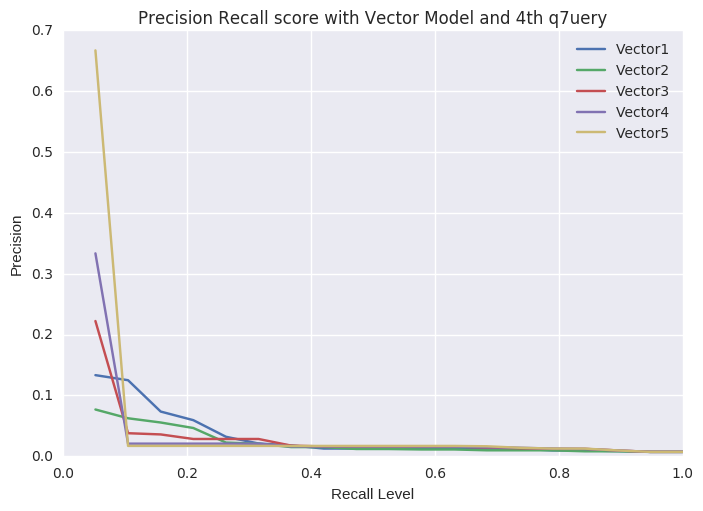

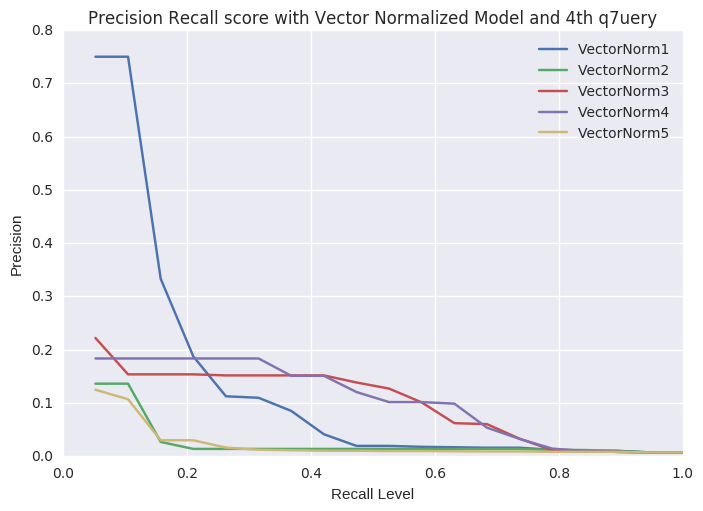

In [197]:
fig = plt.figure()
for model, scores in zip(['Vector1', 'Vector2','Vector3','Vector4','Vector5'], [scores1, scores2, scores3, scores4, scores5]):
    irlist = IRList(q7, scores)
    EM = EvalPrecisionRecall(irlist)
    score = EM.eval(k=20)
    plt.plot(score[:,0], score[:,1], label=model)
plt.legend()
plt.title('Precision Recall score with Vector Model and 4th q7uery')
plt.xlabel('Recall Level')
plt.ylabel('Precision')
plt.show()

fig = plt.figure()
for model, scores in zip(['VectorNorm1', 'VectorNorm2','VectorNorm3','VectorNorm4','VectorNorm5'], [scoresNorm1, scoresNorm2, scoresNorm3, scoresNorm4, scoresNorm5]):
    irlist = IRList(q7, scores)
    EM = EvalPrecisionRecall(irlist)
    score = EM.eval(k=20)
    plt.plot(score[:,0], score[:,1], label=model)
plt.title('Precision Recall score with Vector Normalized Model and 4th q7uery')
plt.xlabel('Recall Level')
plt.ylabel('Precision')
plt.legend()

plt.show()

/home/mcrilo33/.anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


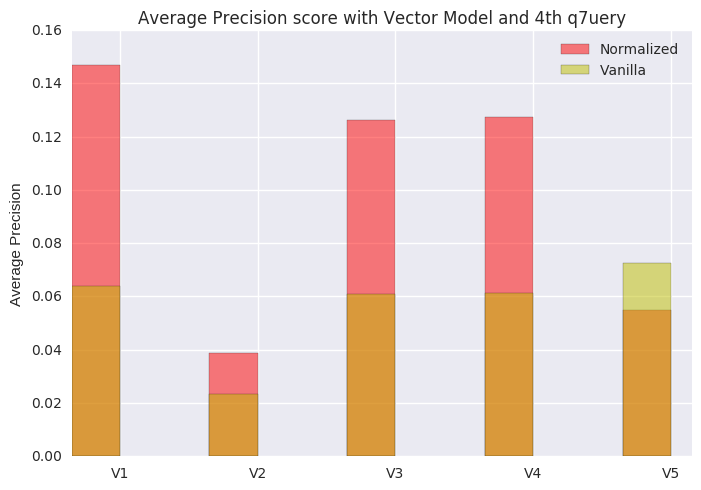

In [199]:
fig, ax = plt.subplots()
score = []
for model, scores in zip(['VectorNorm1', 'VectorNorm2','VectorNorm3','VectorNorm4','VectorNorm5'], [scoresNorm1, scoresNorm2, scoresNorm3, scoresNorm4, scoresNorm5]):
    irlist = IRList(q7, scores)
    EM = EvalPrecisionAverage(irlist)
    score.append(EM.eval())

N = 5
ind = np.arange(N)
width = 0.35
ax.bar(ind, score, width, alpha=0.5, color='r', label='Normalized')
plt.title('Average Precision score with Vector Normalized Model and 4th q7uery')
plt.ylabel('Average Precision')
#ax.set_xticks(ind + width)
#ax.set_xticklabels(('VectorNorm1', 'VectorNorm2','VectorNorm3','VectorNorm4','VectorNorm5'))
score = []
for model, scores in zip(['Vector1', 'Vector2','Vector3','Vector4','Vector5'], [scores1, scores2, scores3, scores4, scores5]):
    irlist = IRList(q7, scores)
    EM = EvalPrecisionAverage(irlist)
    score.append(EM.eval())

N = 5
ind = np.arange(N)
width = 0.35
ax.bar(ind, score, width, alpha=0.5, color='y', label='Vanilla')
plt.title('Average Precision score with Vector Model and 4th q7uery')
plt.ylabel('Average Precision')
ax.set_xticks(ind + width)
ax.set_xticklabels(('V1', 'V2','V3','V4','V5'))
plt.legend()

plt.show()

### Global Evaluation

In [35]:
class EvalIRModel(object):
    
    def __init__(self, models, queries, measures):
        
        self.models = models
        self.queries = queries
        self.measures = measures
        self.results()
        
    def results(self):
        
        results = np.zeros((len(self.models), len(self.queries), len(self.measures)))
        resume = np.zeros((len(self.models), 2))
        descModels = []
        
        i = 0
        for model in self.models:
            print('Computing Model '+str(i)+'... ', model)
            descModels.append(model.__dict__)
            j = 0
            for query in self.queries:
                k = 0
                scores = model.getRanking(query.el)
                irlist = IRList(query, scores)
                for measure in self.measures:
                    measure = measure(irlist)
                    results[i,j,k] = measure.eval()
                    k += 1
                j += 1
            resume[i, 0] = np.mean(results[i,:,:])
            resume[i, 1] = np.var(results[i,:,:])
            i += 1
        
        self.descModels = descModels
        self.resume = resume
        self.outcome = results
    
    def getResults(self):
        
        return self.outcome
        
    def getResume(self):
        
        return self.resume
    
    def getModels(self):
        
        return self.descModels


In [36]:
def saveResults(models, queries, measures, path):

    EM = EvalIRModel(models, queries, measures)
    results = EM.getResults()
    resume = EM.getResume()
    models = EM.getModels()

    # Save results
    resultPath = 'results/'+path+'TrainResults.txt'
    resumePath = 'results/'+path+'TrainResume.txt'
    modelsPath = 'results/'+path+'Models.txt'
    resultFile = open(resultPath, 'w')
    resumeFile = open(resumePath, 'w')
    modelsFile = open(modelsPath, 'w')
    pickle.dump(results, resultFile)
    pickle.dump(resume, resumeFile)
    pickle.dump(models, modelsFile)
    resultFile.close()
    resumeFile.close()
    modelsFile.close()
    

In [102]:
queries = [query(i, queriesIndexer, relevantIndexer) for i in queriesIndexer.index if i in relevantIndexer.indexFromCol]
models = [vector1, vector2, vector3, vector4, vector5, vectorNorm1, vectorNorm2, vectorNorm3, vectorNorm4, vectorNorm5]
measures = [EvalPrecisionAverage]

# Save results
#saveResults(models, queries, measures, 'vector')

In [106]:
f = open('results/vectorModels.txt', 'r')
descModels = pickle.load(f)
f.close()
print(descModels[0])

{'nDoc': 4204, 'weighter': <__main__.Weighter1 object at 0x7f22d592fe50>, 'indexer': <IndexerCACM.IndexerCACM object at 0x7f22dd19a150>, 'normalized': False}


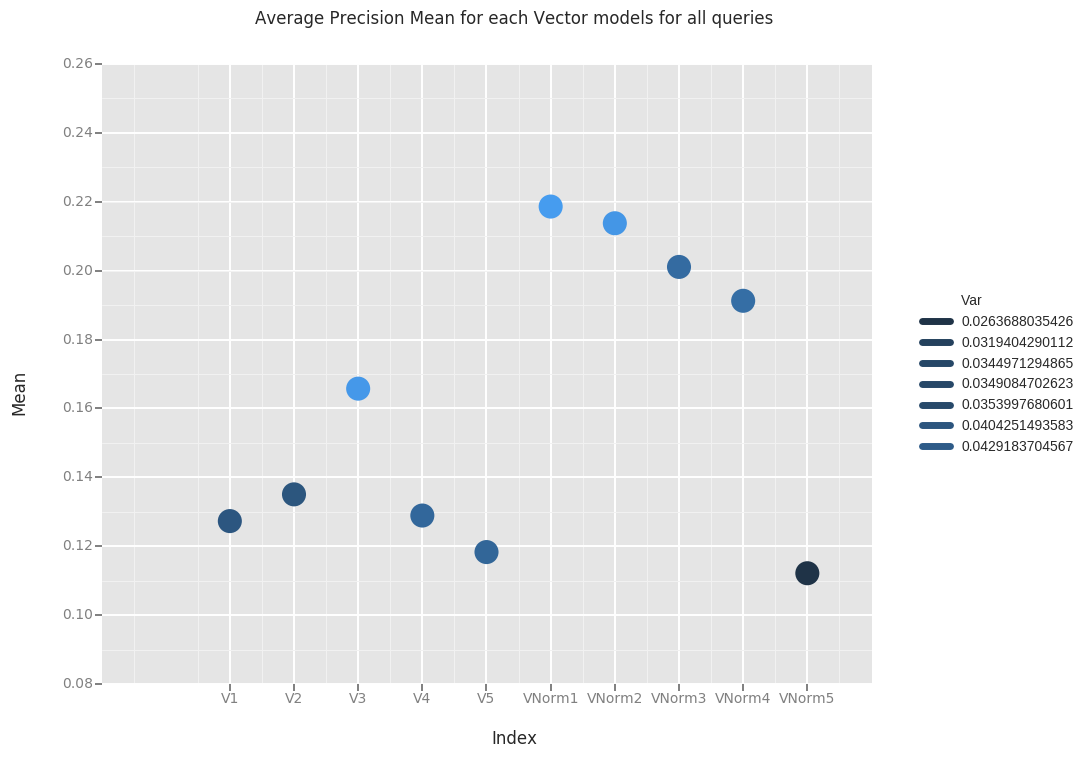

<ggplot: (8736714415097)>

In [209]:
# load resume
f = open('results/vectorResume.txt', 'r')
resume = pickle.load(f)
f.close()

new = pd.DataFrame(data=resume, index=['vector1', 'vector2', 'vector3', 'vector4', 'vector5', 'vectorNorm1', 'vectorNorm2', 'vectorNorm3', 'vectorNorm4', 'vectorNorm5'], columns=['Mean', 'Var'])
new['Index'] = np.arange(10)

ggplot(aes(x='Index', y='Mean', color='Var'), data=new) + \
    geom_point(size=300) + \
    scale_x_continuous(breaks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], \
                      labels=['V1', 'V2', 'V3', 'V4', 'V5', 'VNorm1', 'VNorm2', 'VNorm3', 'VNorm4', 'VNorm5']) + \
    ggtitle('Average Precision Mean for each Vector models for all queries')

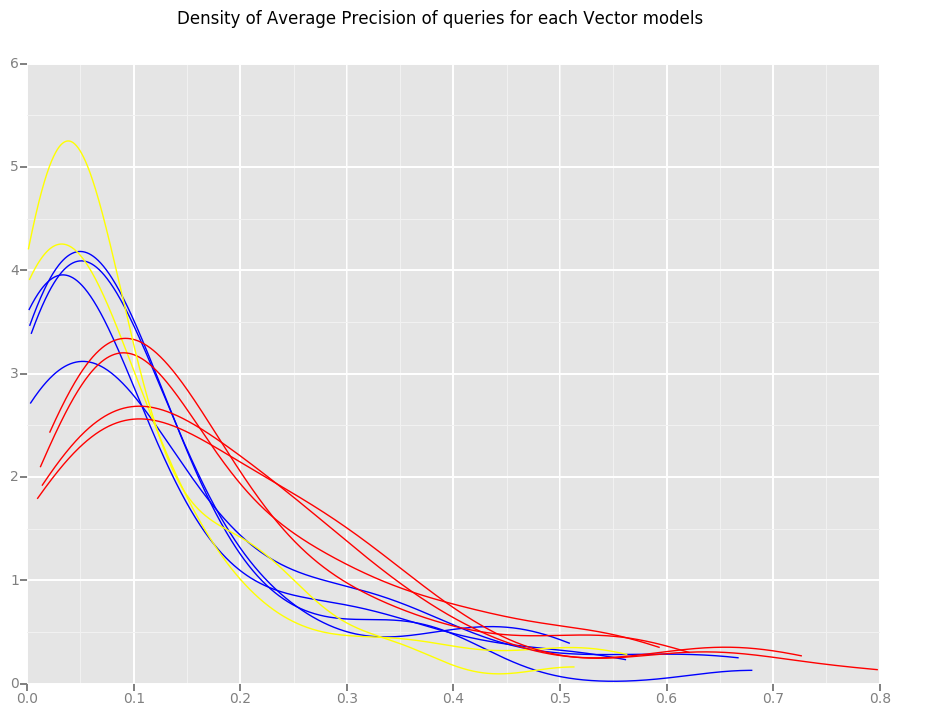

<ggplot: (8736715935757)>

In [142]:
f = open('results/vectorResults.txt', 'r')
results = pickle.load(f)
results = results[:,:-1]
f.close()
ggplot(aes(x=0), data=pd.DataFrame(results[0])) + \
    geom_density(color='blue') + \
    geom_density(aes(x=0), color='blue', data=pd.DataFrame(results[1])) + \
    geom_density(aes(x=0), color='blue', data=pd.DataFrame(results[2])) + \
    geom_density(aes(x=0), color='blue', data=pd.DataFrame(results[3])) + \
    geom_density(aes(x=0), color='yellow', data=pd.DataFrame(results[4])) + \
    geom_density(aes(x=0), color='red', data=pd.DataFrame(results[5])) + \
    geom_density(aes(x=0), color='red', data=pd.DataFrame(results[6])) + \
    geom_density(aes(x=0), color='red', data=pd.DataFrame(results[7])) + \
    geom_density(aes(x=0), color='red', data=pd.DataFrame(results[8])) + \
    geom_density(aes(x=0), color='yellow', data=pd.DataFrame(results[9])) + \
    ggtitle('Histogram of Average Precision of queries for each Vector models')

We can see that improvement between models gives better best queries average precision score.